In [71]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from textloader import *
#from generate import *
import datetime
from pathlib import Path
import sys
import unicodedata
import string
from typing import List
#from torch.utils.data import Dataset, DataLoader
import torch
import re
from textloader import  string2code, id2lettre
import math
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# tp5.py

In [88]:

#  TODO: 

def maskedCrossEntropy(output: torch.Tensor, target: torch.LongTensor, padcar: int):
    """
    :param output: Tenseur length x batch x output_dim,
    :param target: Tenseur length x batch
    :param padcar: index du caractere de padding
    """
    #  TODO:  Implémenter maskedCrossEntropy sans aucune boucle, la CrossEntropy qui ne prend pas en compte les caractères de padding.
    mask = (target != padcar)
    loss = torch.nn.functional.cross_entropy(output.permute(0,2,1), target, reduction='none')
    return torch.mean(loss * mask)
    

class RNN(nn.Module):
    def __init__(self, dim_input, dim_latent, dim_output, dim_emb):
        super().__init__()
        self._dim_input = dim_input
        self._dim_latent = dim_latent
        self._dim_emb = dim_emb
        
        self.lin_i = nn.Linear(dim_emb, dim_latent, bias=False)
        self.lin_h = nn.Linear(dim_latent, dim_latent, bias=True)
        self.lin_d = nn.Linear(dim_latent, dim_output, bias=True)
        self._tanh = nn.Tanh() 

    def one_step(self,x,h):
        return self._tanh(self.lin_i(x)+ self.lin_h(h) ) 
    
    def forward(self,x):
        l = x.shape[0]
        batch = x.shape[1]
        h = torch.zeros(batch, self._dim_latent)
        sequence = [h] 
        for i in range(l) : 
            hi = self.one_step(x[i], sequence[-1])
            sequence.append(hi)
        return sequence[1:]

    def decode(self, h, type="many-to-one"):
        if type=="many-to-one":
            return self.lin_d(h)
        else : 
            seq = []
            for hi in h: 
                seq.append(self.lin_d(hi))
                
            return torch.stack(seq)
    
    def embedding(self,x):
        lin_e = torch.nn.Embedding(self._dim_input, self._dim_emb)
        return lin_e(x)



class LSTM(RNN):
    #  TODO:  Implémenter un LSTM
    def __init__(self, dim_input, dim_latent, dim_output, dim_emb):
        # x_emb : (length, batch, dim_emb)
        # h : (batch, dim_latent)
        # c : (batch, dim_latent)

        super().__init__(dim_input, dim_latent, dim_output, dim_emb)
        
        self._tanh = nn.Tanh() 
        self._sig = nn.Sigmoid()
        
        self.lin_ft = nn.Linear(dim_emb+dim_latent, dim_latent)
        self.lin_it = nn.Linear(dim_emb+dim_latent, dim_latent)
        self.lin_ct = nn.Linear(dim_emb+dim_latent, dim_latent)
        self.lin_ot = nn.Linear(dim_emb+dim_latent, dim_latent)

    def one_step(self, x_t, h, c):
        # x_t : (batch, dim_emb)
        # h_t-1 : (batch, dim_latent)
        # c_t-1 : (batch, dim_latent)
        
        concat = torch.cat((h,x_t), dim=1)
        ft = self._sig(self.lin_ft(concat))
        it = self._sig(self.lin_it(concat))
        ct = ft * c + it * self._tanh(self.lin_ct(concat))
        ot = self._sig(self.lin_ot(concat))
        ht = ot * self._tanh(ct)
        return ht, ct
        
    def forward(self, x):
        l = x.shape[0]
        batch = x.shape[1]
        h = torch.zeros(batch, self._dim_latent)
        c = torch.zeros(batch, self._dim_latent)
        sequence_h = [h] 
        sequence_c = [c]
        for i in range(l) : 
            hi, ci = self.one_step(x[i], sequence_h[-1], sequence_c[-1])
            sequence_h.append(hi)
            sequence_c.append(ci)

        return sequence_h[1:], sequence_c[1:]

class GRU(RNN):
    #  TODO:  Implémenter un LSTM
    def __init__(self, dim_input, dim_latent, dim_output, dim_emb):
        # x_emb : (length, batch, dim_emb)
        # h : (batch, dim_latent)
        # c : (batch, dim_latent)
        super().__init__(dim_input, dim_latent, dim_output, dim_emb)
        self._tanh = nn.Tanh() 
        self._sig = nn.Sigmoid()
        
        self.lin_zt = nn.Linear(dim_emb+dim_latent, dim_latent, bias = False)
        self.lin_rt = nn.Linear(dim_emb+dim_latent, dim_latent, bias = False)
        self.lin_h = nn.Linear(dim_emb+dim_latent, dim_latent, bias = False)

    def one_step(self, x_t, h):
        # x_t : (batch, dim_emb)
        # h_t-1 : (batch, dim_latent)
        # c_t-1 : (batch, dim_latent)
        
        concat = torch.cat((h,x_t), dim=1)
        zt = self._sig(self.lin_zt(concat))
        rt = self._sig(self.lin_rt(concat))

        concat2 = torch.cat((rt*h, x_t), dim=1)

        ht = (1-zt) * h + zt * self._tanh(self.lin_h(concat2))
      
        return ht

#  TODO:  Reprenez la boucle d'apprentissage, en utilisant des embeddings plutôt que du one-hot


# textloader.py

In [69]:


## Token de padding (BLANK)
PAD_IX = 0
## Token de fin de séquence
EOS_IX = 1

LETTRES = string.ascii_letters + string.punctuation + string.digits + ' '
id2lettre = dict(zip(range(2, len(LETTRES)+2), LETTRES))
id2lettre[PAD_IX] = '<PAD>' ##NULL CHARACTER
id2lettre[EOS_IX] = '<EOS>'
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))


def normalize(s):
    """ enlève les accents et les caractères spéciaux"""
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """prend une séquence de lettres et renvoie la séquence d'entiers correspondantes"""
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ prend une séquence d'entiers et renvoie la séquence de lettres correspondantes """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)


class TextDataset(Dataset):
    def __init__(self, text: str, *, maxsent=None, maxlen=None):
        """  Dataset pour les tweets de Trump
            * fname : nom du fichier
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        self.phrases = [re.sub(' +',' ',p[:maxlen]).strip() +"." for p in text.split(".") if len(re.sub(' +',' ',p[:maxlen]).strip())>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.maxlen = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, i):
        return string2code(self.phrases[i])

    
def pad_collate_fn(samples: List[List[int]]):
    #  TODO:  Renvoie un batch à partir d'une liste de listes d'indexes (de phrases) qu'il faut padder.
    samples = [torch.cat((sample, torch.tensor([EOS_IX]))) for sample in samples]
    batch_size = len(samples)
    max_len = max(len(sample) for sample in samples)
    for i, sample in enumerate(samples):
        padding = [ PAD_IX for _ in range(max_len - sample.shape[0])]
        samples[i] = torch.cat((sample,torch.tensor(padding)))
    return torch.stack(samples, dim=1)

In [3]:
test = "C'est. Un. Test."
pred = "C'ess. Un. Tast."
ds = TextDataset(test)
ds_pred = TextDataset(pred)
loader = DataLoader(ds, collate_fn=pad_collate_fn, batch_size=3)
loader_pred = DataLoader(ds_pred, collate_fn=pad_collate_fn, batch_size=3)
y = None
for x in loader : 
    y = x
y = y.long()
pred = None
for x in loader_pred : 
    pred = x
pred = torch.nn.functional.one_hot(pred.long(), num_classes=len(lettre2id))
pred = torch.Tensor.float(pred)


In [4]:
maskedCrossEntropy(pred, y, PAD_IX)

tensor(3.0033)

# generate.py

In [236]:


#  TODO:  Ce fichier contient les différentes fonction de génération

def generate(rnn, emb, decoder, eos, start="", maxlen=200, is_lstm=False):
    """  Fonction de génération (l'embedding et le decodeur être des fonctions du rnn). Initialise le réseau avec start (ou à 0 si start est vide) et génère une séquence de longueur maximale 200 ou qui s'arrête quand eos est généré.
        * rnn : le réseau
        * emb : la couche d'embedding
        * decoder : le décodeur
        * eos : ID du token end of sequence
        * start : début de la phrase
        * maxlen : longueur maximale
    """
    #  TODO:  Implémentez la génération à partir du RNN, et d'une fonction decoder qui renvoie les logits (logarithme de probabilité à une constante près, i.e. ce qui vient avant le softmax) des différentes sorties possibles
    sentence = start
    if start=="":
        h_i = torch.zeros(1,rnn._dim_latent)
        c_i = torch.zeros(1,rnn._dim_latent)
    else : 
        start = string2code(start)
        start = emb(start).unsqueeze(1)
        h_i = rnn(start)[-1]
        
        if is_lstm : 
            h_i,c_i = rnn(start)
            h_i = h_i[-1]
            c_i = c_i[-1]
        else : 
            h_i = rnn(start)[-1]


    for _ in range(maxlen):
        yhat = decoder(h_i, type="many-to-one").softmax(dim=1)
        x_i = torch.multinomial(yhat, 1)[0]
        if x_i[0] == eos : 
            break
        
        car = code2string(x_i)
        sentence += car

        if is_lstm : 
            h_i,c_i = rnn.one_step(emb(x_i), h_i, c_i)
        else : 
            h_i = rnn.one_step(emb(x_i), h_i)

    return sentence
        


def generate_beam(rnn, emb, decoder, eos, k, start="", maxlen=200):
    """
        Génere une séquence en beam-search : à chaque itération, on explore pour chaque candidat les k symboles les plus probables; puis seuls les k meilleurs candidats de l'ensemble des séquences générées sont conservés (au sens de la vraisemblance) pour l'itération suivante.
        * rnn : le réseau
        * emb : la couche d'embedding
        * decoder : le décodeur
        * eos : ID du token end of sequence
        * k : le paramètre du beam-search
        * start : début de la phrase
        * maxlen : longueur maximale
    """
    #  TODO:  Implémentez le beam Search

    if start=="":
        h_i = torch.zeros(1,rnn._dim_latent)
    else : 
        start_code = string2code(start)
        start_emb = emb(start_code).unsqueeze(1)
        h_i = rnn(start_emb)[-1]

    K = [(start, h_i, 1)]
    for lg in range(maxlen):
        #print("---------- "+str(lg)+" --------------")
        k_temp = []
        for seq, h, p in K:
            
            h_t = h

            yhat = decoder(h_t, type="many-to-one").softmax(dim=1)
            top_k_probas, top_k_x_i = torch.topk(yhat, k)
            top_k_probas = [torch.log(p) for p in top_k_probas]
            liste_seq = code2string(top_k_x_i[0])
            k_temp += [(seq+liste_seq[i], h, p+top_k_probas[0][i]) for i in range(k)]

        k_temp.sort(key = lambda x: -x[2].item())
        k_temp = k_temp[:k]
        K = [(seq, rnn.one_step(emb(string2code(seq[-1])),h_i), p) if seq[-1]!=eos else (seq, h_i, p) for seq, h_i, p in k_temp ]
        k_temp = None
    K.sort(key = lambda x: -x[2])
    return K[0][0]
        

# p_nucleus
def p_nucleus(decoder, alpha: float):
    """Renvoie une fonction qui scalcule la distribution de probabilité sur les sorties

    Args:
        * decoder: renvoie les logits étant donné l'état du RNN
        * alpha (float): masse de probabilité à couvrir
    """
    def compute(h):
        """Calcule la distribution de probabilité sur les sorties

        Args:
           * h (torch.Tensor): L'état à décoder
        """
        #  TODO:  Implémentez le Nucleus sampling ici (pour un état s)
    return compute


# Tests 

In [90]:

def learn(modele, data, epoch = 10, dim_input = len(id2lettre), is_lstm = False, dim_latent = 50,dim_output = dim_input, dim_emb = 80, batch_size=BATCH_SIZE, path=PATH, ):

    writer = SummaryWriter("trump/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



    optimizer = torch.optim.Adam(modele.parameters(), lr=1e-2, weight_decay=1e-5)


    liste_loss = []
    liste_loss_test = []
    for epoch in tqdm(range(epoch)):
        
        liste_loss_tmp = []

        for x in data:
            y = torch.vstack((x[1:],  torch.ones(x.shape[1])*PAD_IX))

            x_emb = modele.embedding(x.long())
            optimizer.zero_grad()
            
            if is_lstm:
                liste_h,_ = modele(x_emb) 
            else : 
                liste_h = modele(x_emb) 

            yhat = modele.decode(liste_h, "many-to-many")

            loss = maskedCrossEntropy(yhat, y.long(), PAD_IX)


            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()

            # Utilisez TensorBoard pour surveiller la magnitude des gradients
            #for name, param in modele.named_parameters():
            #    if param.grad is not None:
            #        writer.add_histogram(name + '/grad', param.grad, epoch)

            # Implémentez le "gradient clipping"
            torch.nn.utils.clip_grad_norm_(modele.parameters(), max_norm=1.0)  
            
            optimizer.step()
            
            with torch.no_grad():
                liste_loss_tmp.append(loss.item())
            
        liste_loss.append(np.mean(liste_loss_tmp))

        
    plt.figure()
    plt.plot(np.arange(len(liste_loss)), liste_loss, label='Loss train', color='tab:orange')
    plt.xlabel("Iterations")
    plt.title("Loss en train et en test")
    plt.legend(loc='upper left')
    plt.show()

## RNN

100%|██████████| 10/10 [04:15<00:00, 25.59s/it]


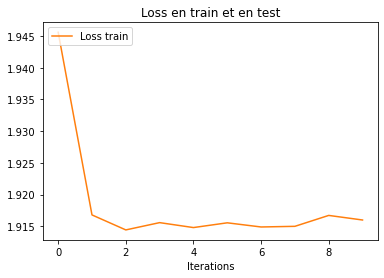

In [107]:
BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"

data_trump = DataLoader(TextDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=100), collate_fn=pad_collate_fn, batch_size= BATCH_SIZE
, shuffle=True)


dim_input = len(id2lettre)
dim_latent = 50
dim_output = dim_input
dim_emb = 80

epoch = 10


rnn = RNN(dim_input, dim_latent, dim_input, dim_emb)
learn(rnn, data_trump)

In [114]:
generate(rnn, rnn.embedding, rnn.decode, EOS_IX, start="Hello", maxlen=200)

'Helloirp3nonilsegengbtfktAgApifv ye .en rootoortfsat, tmounvmrnfh rcaio'

## LSTM

100%|██████████| 10/10 [08:22<00:00, 50.20s/it]


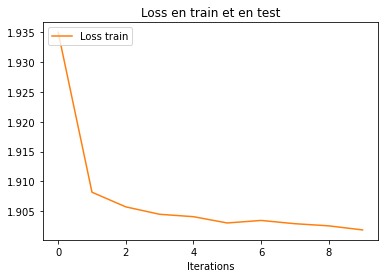

In [96]:

BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"

data_trump = DataLoader(TextDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=100), collate_fn=pad_collate_fn, batch_size= BATCH_SIZE
, shuffle=True)


dim_input = len(id2lettre)
dim_latent = 50
dim_output = dim_input
dim_emb = 80

epoch = 10


lstm = LSTM(dim_input, dim_latent, dim_input, dim_emb)
learn(lstm, data_trump, is_lstm=True)

In [104]:
s = generate(lstm, lstm.embedding, lstm.decode, EOS_IX, start="Hello", maxlen=200,  is_lstm=True)
print(s)

Helloetdnrrs.a, Apiri ou'eln drt ,OrC. thy ehthuuturmmeec soe aoe wtetr  r cero


# GRU

100%|██████████| 10/10 [08:43<00:00, 52.38s/it]


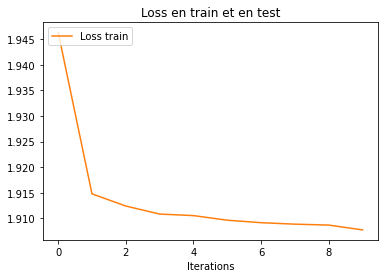

In [41]:

BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"

data_trump = DataLoader(TextDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=100), collate_fn=pad_collate_fn, batch_size= BATCH_SIZE
, shuffle=True)


dim_input = len(id2lettre)
dim_latent = 50
dim_output = dim_input
dim_emb = 80

epoch = 10


gru = GRU(dim_input, dim_latent, dim_input, dim_emb)
#learn(gru, data_trump)

In [226]:
s = generate(gru, gru.embedding, gru.decode, EOS_IX, start="Hello ", maxlen=200)
print(s)

Hello s rchgr.eth ho naSnlregy bup,fdmn er.a


# beam search

In [252]:
generate_beam(gru, gru.embedding, gru.decode, id2lettre[EOS_IX], 2, start="Hello", maxlen=10)

'Hello          '